Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers? i.e leave some data out and refit
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [3]:
import numpy as np
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [24]:
T90=np.array(data[6],dtype=float)
#print(T90)

fluence = np.array(data[9], dtype = float)
print(fluence)

[-9.9900e+02  5.8068e-06  3.3510e-06 ...  2.4858e-08  1.6510e-07
  2.6055e-06]


Let's first draw an histogram of the T90 samples.

In [7]:
import matplotlib.pyplot as plt

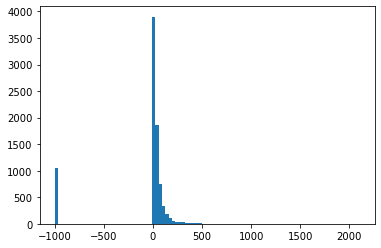

In [15]:
plt.hist(T90, int(np.sqrt(len(T90))))
plt.show()

There are some points at -1000: these are the outliers! Let's first remove them.

In [26]:
T90_index = []

for i in range(len(T90)):
    if T90[i] == -999: T90_index.append(i)

T90_best = np.delete(T90, T90_index)

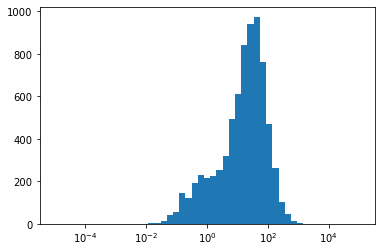

In [43]:
plt.hist(T90_best, np.logspace(-5, 5))
plt.semilogx()
plt.show()

What about the fluence?

In [28]:
fluence_index = []

for i in range(len(fluence)):
    if fluence[i] == -999: fluence_index.append(i)

fluence_best = np.delete(T90, fluence_index)

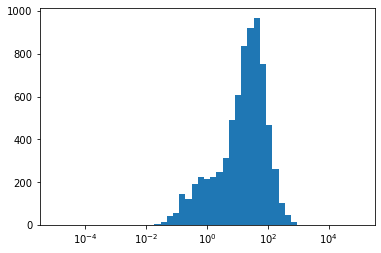

In [73]:
plt.hist(fluence_best, np.logspace(-5, 5))
plt.semilogx()
plt.show()

Let's try to find two clusters in the T90 distribution.

In [45]:
from sklearn.cluster import KMeans

In [83]:
kmeans = KMeans(n_clusters = 2)
X = np.log(T90_best).reshape(-1, 1)
kmeans.fit(X)

KMeans(n_clusters=2)

In [84]:
y = kmeans.predict(X)

In [85]:
kmeans.cluster_centers_[0]

array([-0.09087793])

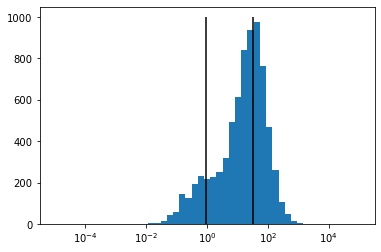

In [87]:
plt.vlines(np.exp(kmeans.cluster_centers_[:]), 0, 1000, color = 'black')
plt.hist(T90_best, np.logspace(-5, 5))
plt.semilogx()
plt.show()

dividiamo i due cluster in due histogrammi separati e plottiamoli.

In [90]:
c1 =[]
c2 =[]
for i in range(len(T90_best)):
    if (y[i] == 0): c1.append(T90_best[i])
    else: c2.append(T90_best[i])
        
c1 = np.array(c1)
c2 = np.array(c2)

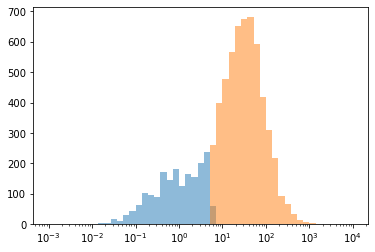

In [101]:
plt.hist(c1, np.logspace(-3, 4), alpha = 0.5)
plt.hist(c2, np.logspace(-3, 4), alpha = 0.5)
plt.semilogx()
plt.show()